In [1]:
from pathlib import Path
import numpy as np
import torch
import hydra
from omegaconf import OmegaConf
import matplotlib.pyplot as plt

# Using Hydra

## Introduction: hydra

`hydra` is a Python library we use to load and manage configuration files. It is a powerful tool that allows us to define configuration files in a structured way and load them into our Python code.

To use `hydra`, we need to define a relative path to a configuration file (folder with configuration files) and then load it into our code.



In [2]:
cfg_path = "./../configs" # Path to the config files. Should be relative to the script location!
cfg_name = "test" # Name of the config file to load

There are two ways of loading configuration files using `hydra`:

1. **Imperative API**: This is the most common way of loading configuration files. We use the `OmegaConf` object to load the configuration files and access the configuration parameters.

Use the following code to load a configuration file using the imperative API:

```python
with hydra.initialize(config_path=cfg_path):
    cfg = hydra.compose(config_name=cfg_name)
```

Inside the context manager (`with` block), we can access the configuration parameters using the `cfg` object directly.

2. **Declarative API**: This is a new way of loading configuration files. We use the `@hydra.main()` decorator to load the configuration files and access the configuration parameters.

```python
@hydra.main(config_path=cfg_path, config_name=cfg_name)
def my_app(cfg: DictConfig) -> None:
    pass
```
The `cfg` object is passed as an argument to the function decorated with `@hydra.main()`.

In this notebook, we will be using Imperative API since the Declarative API is not supported in Jupyter notebooks. In scripts, however, you can use the Declarative API to load configuration files.

`hydra.compose()` takes care of loading all the configuration files mentioned in the passed file, and merges them into a single configuration object. It also resolves the configuration parameters and provides a clean interface to access the configuration parameters.

It is called automatically when we use the `@hydra.main()` decorator, but we need to call it explicitly when using the imperative API.

In [3]:
def plot_imgs(data, slice=128):
    print("Data keys:", data.keys())
    if 'name' in data:
        print("Name:", data['name'])
    
    # print shape, type, range, device
    print(f"Image shape: {data['image'].shape}, type: {data['image'].dtype}, range: [{data['image'].min()}, {data['image'].max()}], device: {data['image'].device}")
    print(f"Label shape: {data['label'].shape}, type: {data['label'].dtype}, range: [{data['label'].min()}, {data['label'].max()}], device: {data['label'].device}")


    # if cuda tensor, move to cpu
    if data["image"].is_cuda:
        data["image"] = data["image"].cpu()
    if data["label"].is_cuda:
        data["label"] = data["label"].cpu()
    
    # remove channel dimension
    data["image"] = data["image"].squeeze()
    data["label"] = data["label"].squeeze()
    
    # plot image label
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(data["image"][:, slice, :], cmap="gray")
    axes[0].set_title("Image")
    axes[0].axis("off")
    axes[1].imshow(data["label"][:, slice, :], cmap='jet')
    axes[1].set_title("Label")
    axes[1].axis("off")
    plt.show()
    

# Testing different datasets

In [4]:
# define paths to the corresponding config files

cfg_path = "./../configs/dataset"

## Real images dataset

In [5]:
cfg_name = 'testing'

`configs/dataset/testing.yaml` contains following configuration for real images dataset:

```
defaults:
  - transforms/inference

_target_: fetalsyngen.data.datasets.FetalTestDataset
bids_path: ./data
sub_list: null
```

See how in the code below we load the configuration file and hydra takes care of loading the `configs/dataset/transforms/inference.yaml` file as well and sets the `transforms` parameter in the configuration object.


/home/vzalevskyi/miniconda3/envs/fetalsyngen/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'testing': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


Composed config: {'transforms': {'_target_': 'monai.transforms.Compose', 'transforms': [{'_target_': 'monai.transforms.Orientationd', 'keys': ['image', 'label'], 'axcodes': 'RAS'}, {'_target_': 'monai.transforms.SignalFillEmptyd', 'keys': ['image', 'label'], 'replacement': 0, 'allow_missing_keys': True}, {'_target_': 'monai.transforms.CropForegroundd', 'keys': ['image', 'label'], 'source_key': 'image', 'allow_smaller': True, 'margin': 0, 'allow_missing_keys': True}, {'_target_': 'monai.transforms.Spacingd', 'keys': ['image', 'label'], 'pixdim': [0.5, 0.5, 0.5], 'mode': ['bilinear', 'nearest'], 'allow_missing_keys': True}, {'_target_': 'monai.transforms.SpatialPadd', 'keys': ['image', 'label'], 'spatial_size': [256, 256, 256], 'mode': 'constant', 'allow_missing_keys': True}, {'_target_': 'monai.transforms.CenterSpatialCropd', 'keys': ['image', 'label'], 'roi_size': [256, 256, 256], 'allow_missing_keys': True}, {'_target_': 'monai.transforms.ScaleIntensityd', 'keys': ['image'], 'minv': 0

Using /home/vzalevskyi/.cache/torch_extensions/py310_cu124 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/vzalevskyi/.cache/torch_extensions/py310_cu124/transform_convert_cuda/build.ninja...
/home/vzalevskyi/miniconda3/envs/fetalsyngen/lib/python3.10/site-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module transform_convert_cuda...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module transform_convert_cuda...
Using /home/vzalevskyi/.cache/torch_extensions/py310_cu124 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/vzalevskyi/.cache/torch_extensions/py310_cu124/slice_acq_cuda/build.ninja...
/home/vzalevskyi/miniconda3/envs/fetalsyngen/lib/python3.10/site-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module slice_acq_cuda...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module slice_acq_cuda...


ninja: no work to do.
Data keys: dict_keys(['image', 'label', 'name', 'foreground_start_coord', 'foreground_end_coord'])
Name: sub-sta38
Image shape: torch.Size([1, 256, 256, 256]), type: torch.float32, range: [0.0, 1.0], device: cpu
Label shape: torch.Size([1, 256, 256, 256]), type: torch.float32, range: [0.0, 7.0], device: cpu


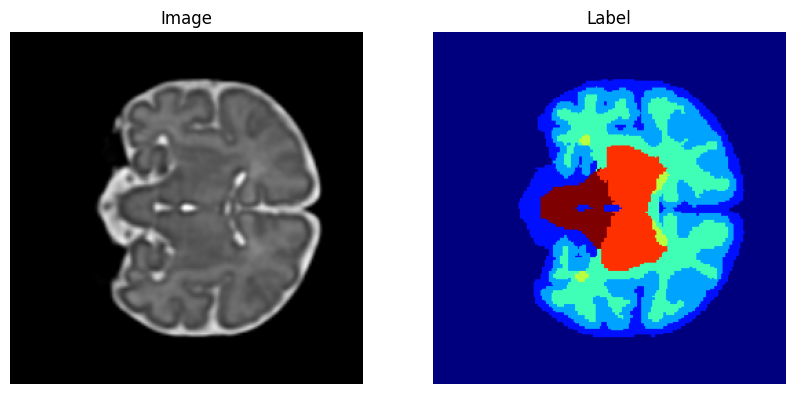

In [6]:
with hydra.initialize(config_path=cfg_path, version_base='1.2'):
    cfg = hydra.compose(config_name=cfg_name)
    print(f'Composed config: {cfg}')
    # print(OmegaConf.to_yaml(cfg))
    cfg.bids_path = './../data' # update the BIDS path to the relative path from current script location
    dataset = hydra.utils.instantiate(cfg)
    sample = dataset[0]
    plot_imgs(sample)

### Real training images dataset

In [7]:
cfg_name = "real_train"

`configs/dataset/real_train.yaml` contains following configuration for real images dataset:

```
defaults:
  - generator/default

_target_: fetalsyngen.data.datasets.FetalSynthDataset
bids_path: ./data
seed_path: null
sub_list: null
load_image: True
image_as_intensity: True
```

See how in the code below we load the configuration file and hydra takes care of loading the `configs/dataset/generator/default.yaml` file as well and sets the `generator` parameter in the configuration object.


/home/vzalevskyi/miniconda3/envs/fetalsyngen/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'real_train': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


Composed config: {'generator': {'_target_': 'fetalsyngen.generator.model.FetalSynthGen', 'shape': [256, 256, 256], 'resolution': [0.5, 0.5, 0.5], 'device': 'cuda:0', 'intensity_generator': {'_target_': 'fetalsyngen.generator.intensity.rand_gmm.ImageFromSeeds', 'min_subclusters': 1, 'max_subclusters': 3, 'seed_labels': [0, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], 'generation_classes': [0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]}, 'spatial_deform': {'_target_': 'fetalsyngen.generator.deformation.affine_nonrigid.SpatialDeformation', 'device': '${..device}', 'size': '${..shape}', 'prob': 1, 'flip_prb': 0.5, 'max_rotation': 20, 'max_shear': 0.02, 'max_scaling': 0.1, 'nonlinear_transform': True, 'nonlin_scale_min': 0.03, 'nonlin_scale_max': 0.06, 'nonlin_s

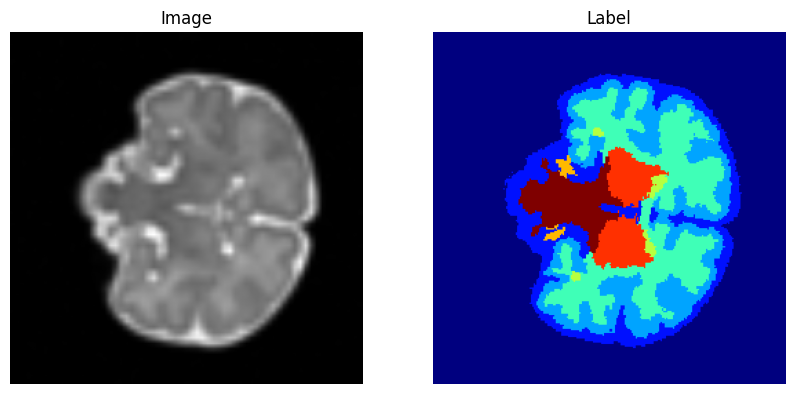

In [8]:
with hydra.initialize(config_path=cfg_path, version_base="1.2"):
    cfg = hydra.compose(config_name=cfg_name)
    print(f"Composed config: {cfg}")
    # print(OmegaConf.to_yaml(cfg))
    cfg.bids_path = "./../data"  # update the BIDS path to the relative path from current script location
    dataset = hydra.utils.instantiate(cfg)
    sample = dataset[0]
    plot_imgs(sample)

## Synthetic images dataset

In [9]:
cfg_name = "synth_train"

`configs/dataset/synth_train.yaml` contains following configuration for real images dataset:

```
defaults:
  - generator/default

_target_: fetalsyngen.data.datasets.FetalSynthDataset
bids_path: ./data
seed_path: ./data/derivatives/seeds
sub_list: null
load_image: False
image_as_intensity: False
```

See how in the code below we load the configuration file and hydra takes care of loading the `configs/dataset/generator/default.yaml` file as well and sets the `generator` parameter in the configuration object.


Composed config: {'generator': {'_target_': 'fetalsyngen.generator.model.FetalSynthGen', 'shape': [256, 256, 256], 'resolution': [0.5, 0.5, 0.5], 'device': 'cuda:0', 'intensity_generator': {'_target_': 'fetalsyngen.generator.intensity.rand_gmm.ImageFromSeeds', 'min_subclusters': 1, 'max_subclusters': 3, 'seed_labels': [0, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], 'generation_classes': [0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]}, 'spatial_deform': {'_target_': 'fetalsyngen.generator.deformation.affine_nonrigid.SpatialDeformation', 'device': '${..device}', 'size': '${..shape}', 'prob': 1, 'flip_prb': 0.5, 'max_rotation': 20, 'max_shear': 0.02, 'max_scaling': 0.1, 'nonlinear_transform': True, 'nonlin_scale_min': 0.03, 'nonlin_scale_max': 0.06, 'nonlin_s

/home/vzalevskyi/miniconda3/envs/fetalsyngen/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'synth_train': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


{}
Synth params:  {'selected_seeds': {'mlabel2subclusters': {1: 2, 2: 1, 3: 1, 4: 1}}, 'seed_intensities': {'mus': tensor([110.9151,  39.7743,  60.6640,  44.4081, 112.2773,  81.7351, 218.9404,
         38.2935,  50.6874, 218.6385,  76.7444,  36.1455,  90.7592,  27.8453,
         10.3565,  36.5791,  54.5349,  66.6340,   0.0000,  57.7421,  57.1854,
         25.4869,  25.9700,  95.2374,  92.2066,  93.4377,  58.2657,  63.0223,
         46.8038,  94.3651,  53.8528, 106.0581,  93.1756,  49.1870,  83.5179,
         67.8218,  45.1247,  69.3765,  52.3948,  34.1862, 225.0000, 215.9934,
         15.2683, 130.1708, 126.0758,  63.5996, 165.6096, 144.5461, 143.2297,
        162.0230], device='cuda:0'), 'sigmas': tensor([17.6189, 22.9028,  7.4893, 24.5367, 18.6175, 15.7768, 22.9225, 18.0257,
        15.6473, 21.6987, 12.4060, 10.7055,  9.1432, 17.1333,  8.0114, 24.1579,
        19.4132,  6.4121, 19.1266,  6.5813, 14.9337, 22.0112, 24.8563, 21.8087,
         9.3582, 20.0573,  9.3197,  9.8454,  8.0691,

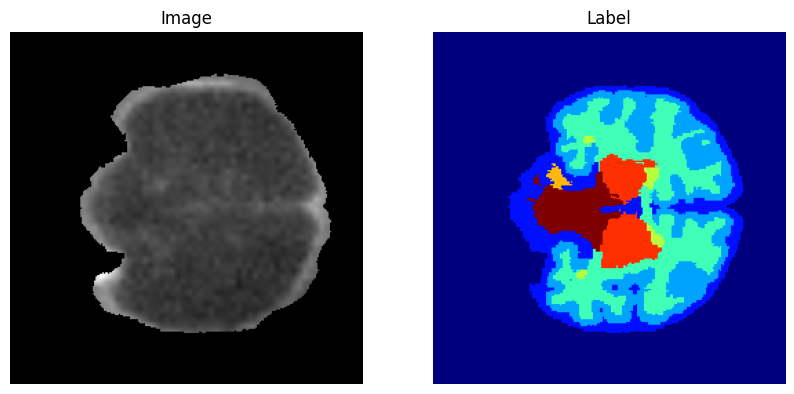

In [10]:
with hydra.initialize(config_path=cfg_path, version_base="1.2"):
    cfg = hydra.compose(config_name=cfg_name)
    cfg.bids_path = "./../data"  # update the BIDS path to the relative path from current script location
    cfg.seed_path = "./../data/derivatives/seeds"
    print(f"Composed config: {cfg}")
    # print(OmegaConf.to_yaml(cfg))
    cfg.bids_path = "./../data"  # update the BIDS path to the relative path from current script location
    dataset = hydra.utils.instantiate(cfg)
    sample = dataset[0]
    plot_imgs(sample)

# Direct instantiation

In [11]:
from fetalsyngen.data.datasets import FetalSynthDataset

from fetalsyngen.generator.model import FetalSynthGen
from fetalsyngen.generator.augmentation.synthseg import RandBiasField, RandGamma, RandNoise, RandResample
from fetalsyngen.generator.deformation.affine_nonrigid import  SpatialDeformation
from fetalsyngen.generator.intensity.rand_gmm import  ImageFromSeeds


intensity_generator = ImageFromSeeds(
    min_subclusters=1,
    max_subclusters=3,
    seed_labels=[ 0, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
    ],
    generation_classes=[
        0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
    ],
    meta_labels=4,
)
spatial_deform = SpatialDeformation(max_rotation=20, max_shear=0.02,max_scaling=0.11,
                                    size=(256, 256, 256), prob=1, nonlinear_transform=True,
                                    nonlin_scale_min=0.03, nonlin_scale_max=0.06,
                                    nonlin_std_max=4, flip_prb=0.5, device='cuda:0')
resampler = RandResample(prob=0.5, max_resolution=1.5, min_resolution=0.5)
bias_field = RandBiasField(prob=0.5, scale_min=0.004, scale_max=0.02, std_min=0.01, std_max=0.3)
noise = RandNoise(prob=0.5, std_min=5, std_max=15)
gamma = RandGamma(prob=0.5, gamma_std=0.1)

generator = FetalSynthGen(shape=(256, 256, 256),
                          resolution=(0.5, 0.5, 0.5),
                          device='cuda:0',
                          intensity_generator=intensity_generator,
                          spatial_deform=spatial_deform,
                          resampler=resampler,
                          bias_field=bias_field,
                          noise=noise,
                          gamma=gamma,
                          )

dataset = FetalSynthDataset(bids_path='./../data', generator=generator,
                            seed_path='./../data/derivatives/seeds', 
                            sub_list=None)



### Print the generated configuration object

Different images will be generated for the same dataset index due to the randomized generator. See example below.

{}
Synth params:  {'selected_seeds': {'mlabel2subclusters': {1: 1, 2: 1, 3: 2, 4: 3}}, 'seed_intensities': {'mus': tensor([171.6744,  43.2540, 162.3128,  93.1950, 214.0770, 221.6636, 124.6653,
         30.8427, 204.8314,  60.5305,  69.7790,  41.8061,  58.1632,  52.7732,
         37.8647,  30.7088,  63.8923,  81.0667, 100.1355,  75.8184,  32.3573,
         68.9457,  79.4661,  57.4316,  75.4487,  47.9852,  10.3207,  21.4820,
         89.7579,  36.9790,  48.7559,   0.0000,  30.8316,  57.0345,  73.2452,
         74.0961,  58.5741,  19.9349,  31.6700,  97.0313,  70.0985, 107.0800,
        225.0000,  59.6673, 182.3524, 211.4937, 219.2361, 188.5571,  86.0112,
        215.5373], device='cuda:0'), 'sigmas': tensor([18.6792,  8.1543, 21.4694,  6.4040,  8.6053, 21.2569, 23.4767, 18.0633,
        11.1378, 15.4109, 14.5751,  5.5319, 13.4055,  5.0036, 15.1005, 19.8461,
        20.2797, 14.5100, 17.6497, 17.2538, 10.1043, 16.9587, 15.8954,  9.5012,
        18.7562, 14.7774,  8.0029, 19.9660, 13.6768,

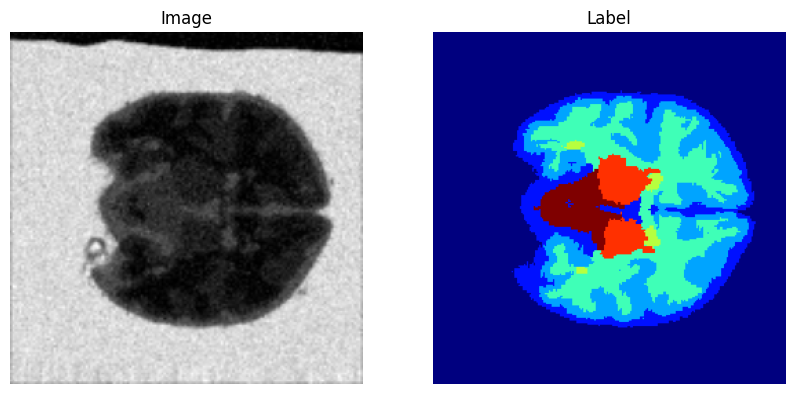

{}
Synth params:  {'selected_seeds': {'mlabel2subclusters': {1: 2, 2: 2, 3: 1, 4: 2}}, 'seed_intensities': {'mus': tensor([ 68.2085,  99.6852, 148.7900, 140.2547, 172.7318,  25.3597, 222.0925,
         77.8385, 117.2164,  85.5017,  80.6654, 161.6892, 120.4783,  91.3816,
        124.9938, 110.7340, 116.0643,  95.5198, 121.6350, 119.2662, 189.7058,
        151.8555, 201.8370, 179.9055, 201.2912, 153.9692, 202.7262, 219.6054,
        225.0000, 203.0421, 141.0091,  97.9115,  76.6873,  99.9071, 152.3261,
        137.8125, 111.7321, 121.5527,  63.1559, 116.5293, 119.5260, 109.1578,
        144.3965, 219.3358, 161.3005, 116.7146, 206.8166, 122.3023,  98.0824,
         53.7700], device='cuda:0'), 'sigmas': tensor([24.4796,  8.5438, 22.4839,  7.8344,  6.8791, 15.2809, 15.5437, 15.8034,
        14.9920, 10.2218, 21.6163, 17.6271,  8.8091,  6.6703,  5.5308, 20.8947,
        21.9819, 15.1826, 14.4437, 13.0625, 13.7080, 19.2709, 21.5135, 19.8149,
        16.5803, 14.2051, 19.1199, 10.9485, 23.5890,

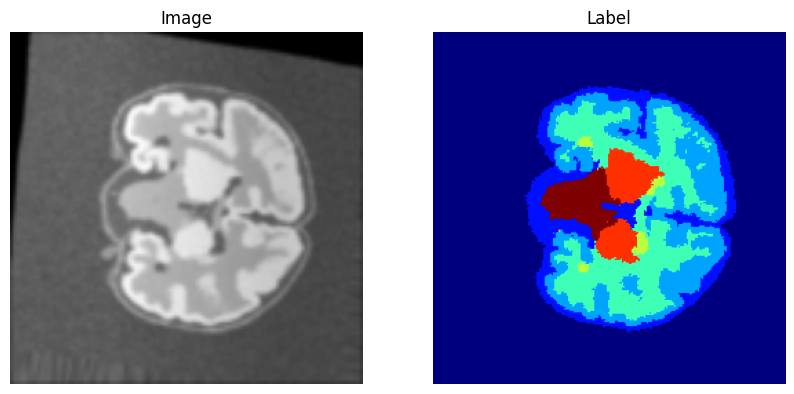

In [12]:
plot_imgs(dataset[0])
plot_imgs(dataset[0])

However, if you want to generate similar images for the same dataset index, you can use  pass to the generator the genparams dictionary with the generation parameters. These generation parameters can be obtained if using the `dataset.sample_with_meta()` rather than `dataset.__getitem__()`.

See how in example below we are able to generate the same images for the same dataset index by passing the genparams dictionary to the generator.

{}
Synth params:  {'selected_seeds': {'mlabel2subclusters': {1: 3, 2: 3, 3: 1, 4: 3}}, 'seed_intensities': {'mus': tensor([ 51.2752,  61.3916, 179.4661,  42.2349, 105.8487, 202.6522,  57.7982,
        222.8844, 206.1047, 196.0202, 197.6429, 188.0681, 129.7784, 134.9186,
        190.8259, 122.4303, 182.3234, 186.0186, 157.5383, 164.2887,  87.4240,
         73.2629,  71.4683, 137.5692, 113.9327,  92.3996,  81.3726,  73.3847,
        105.1874,  54.7764, 131.0639, 101.6458, 152.0462, 108.9006,  79.0838,
         69.4024, 121.5411,  97.2741,  94.4035, 111.0255,  75.5427,  41.2843,
         60.8460, 150.5676,  56.8807, 206.1906, 177.6427, 133.0907, 178.9675,
        130.5016], device='cuda:0'), 'sigmas': tensor([23.2086, 13.9382, 23.5046,  9.0387, 19.9474, 22.5791, 18.3091, 13.7815,
        22.9901, 13.7231, 10.5417, 15.8973, 24.8541, 11.3540, 12.0642, 14.4775,
        22.1338, 23.4229, 21.1016, 15.6028, 15.6163,  7.9284, 14.7362, 23.6727,
        21.4385, 24.1899, 15.2511,  8.1216, 13.2917,

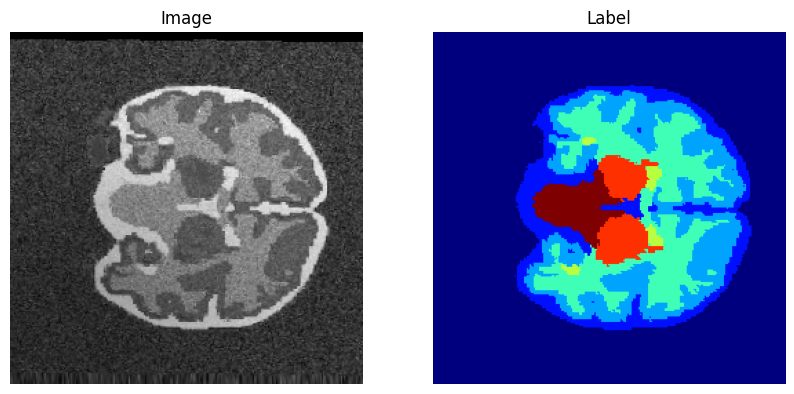

Data keys: dict_keys(['image', 'label', 'name', 'generation_params'])
Name: sub-sta38
Image shape: torch.Size([256, 256, 256]), type: torch.float32, range: [0.0, 1.0], device: cpu
Label shape: torch.Size([256, 256, 256]), type: torch.float32, range: [0.0, 7.0], device: cpu


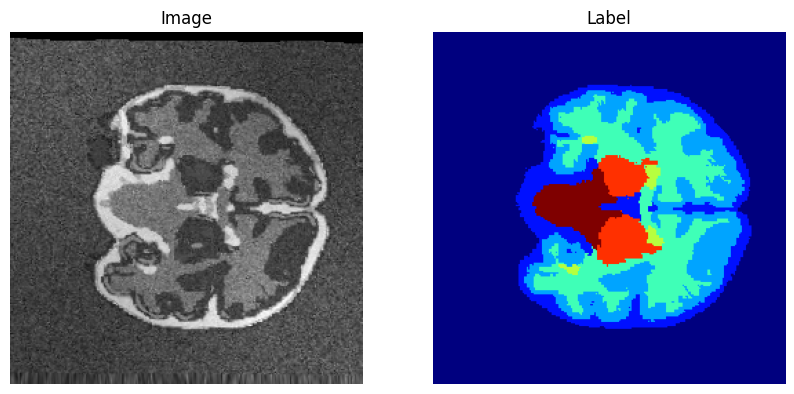

In [13]:
sample = dataset.sample_with_meta(0)
sample_copy = dataset.sample_with_meta(0, genparams=sample['generation_params'])
plot_imgs(data=sample)
plot_imgs(data=sample_copy)

#### Note!
If a generation parameter is set to None, it will be randomly selected by the generator. If you want to generate the same images for the same dataset index, you need to pass the genparams dictionary with the generation parameters.

A Small script below prints the generation parameters that are  different between to sampled images with the same generation parameters.
If they are not printed they are the same.

Note that the generation parameters define **'strength'** of the augmentation. Not necessarily the augmentation itself voxel-wise.


If the generation parameter is None, it still might be randomly selected by the generator.

In [19]:
a = sample["generation_params"]
b = sample_copy["generation_params"]

# compare all the values (including nested dictionaries) to be the same and print the differences
def compare_dicts(a, b, path=""):
    def robust_compare(a, b):
        # print(f"Comparing {a} and {b}")
        if isinstance(a, np.ndarray) and isinstance(b, np.ndarray):
            return not np.all(a == b)
        elif isinstance(a, torch.Tensor) and isinstance(b, torch.Tensor):
            return not torch.all(a == b)
        elif type(a) != type(b):
            return True
        
        return a != b

        # return a!=b

    for key in a.keys():
        if key not in b:
            print(f"Key {path}.{key} not found in b")
        elif isinstance(a[key], dict):
            compare_dicts(a[key], b[key], path=f"{path}.{key}")
        elif robust_compare(a[key], b[key]):
            print(f"Key {path}.{key} has different values: {a[key]} != {b[key]}")

compare_dicts(a, b)

Key .gamma_params.gamma has different values: None != 1.0013195919870812
Key .generation_time has different values: 0.23033642768859863 != 0.2356719970703125
